In [1]:
from helpers.data_load import load_data_from_txt
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from helpers.data_helpers import get_sequence
import matplotlib.pyplot as plt
from numpy.linalg import norm
from tqdm.notebook import tqdm
import faiss
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = load_data_from_txt(path='data/data.txt')

In [3]:
data.head(10)

,EURUSD,numdate,time,open,max,min,close,vol
EURUSD,5,20200701,500,1.12332,1.12364,1.12310,1.12330,245
EURUSD,5,20200701,1000,1.12327,1.12356,1.12310,1.12330,1414
EURUSD,5,20200701,1500,1.12331,1.12351,1.12310,1.12322,1317
EURUSD,5,20200701,2000,1.12322,1.12340,1.12300,1.12323,992
EURUSD,5,20200701,2500,1.12321,1.12346,1.12297,1.12314,982
EURUSD,5,20200701,3000,1.12323,1.12340,1.12310,1.12317,988
EURUSD,5,20200701,3500,1.12330,1.12337,1.12293,1.12307,962
EURUSD,5,20200701,4000,1.12307,1.12328,1.12290,1.12314,1611
EURUSD,5,20200701,4500,1.12303,1.12319,1.12290,1.12311,1279
EURUSD,5,20200701,5000,1.12295,1.12319,1.12290,1.12300,1284


In [4]:
a = get_sequence(df=data, col_name='open', start_point=0, end_point=5)
b = get_sequence(df=data, col_name='open', start_point=5, end_point=10)

In [5]:
(a[:-1] - a[1:])

array([ 5.e-05, -4.e-05,  9.e-05,  1.e-05])

In [6]:
a = np.array([3,4,6,6,2,2,4,5,2,1])
b = np.array([29,41,61,58,22,21,42,51,19,10])
c = np.array([5,1,2,2,1,4,2,2,1,3])

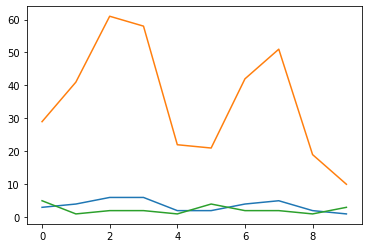

In [7]:
plt.plot(a)
plt.plot(b)
plt.plot(c)

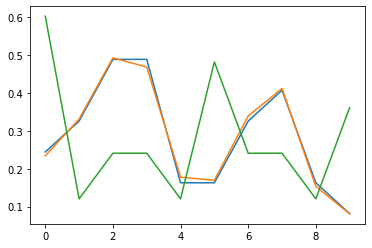

In [8]:
plt.plot(a/norm(a))
plt.plot(b/norm(b))
plt.plot(c/norm(c))

In [9]:
a_norm = a / norm(a)
b_norm = b / norm(b)
c_norm = c / norm(c)

In [10]:
np.median(abs(a_norm - b_norm))

0.008069240662889846

In [11]:
np.median(abs(a_norm - c_norm))

0.2263154497569259

In [12]:
from scipy.spatial.distance import cosine, euclidean
import math

In [13]:
print(euclidean(a_norm, b_norm))
print(euclidean(a_norm, c_norm))
print(euclidean(b_norm, c_norm))

print(cosine(a_norm, b_norm))
print(cosine(a_norm, c_norm))
print(cosine(b_norm, c_norm))



0.03332028794838436
0.7147566081010416
0.7167452099154569
0.0005551207944816117
0.2554385044120533
0.2568618479683764


In [14]:
data

,EURUSD,numdate,time,open,max,min,close,vol
EURUSD,5,20200701,500,1.12332,1.12364,1.12310,1.12330,245
EURUSD,5,20200701,1000,1.12327,1.12356,1.12310,1.12330,1414
EURUSD,5,20200701,1500,1.12331,1.12351,1.12310,1.12322,1317
EURUSD,5,20200701,2000,1.12322,1.12340,1.12300,1.12323,992
EURUSD,5,20200701,2500,1.12321,1.12346,1.12297,1.12314,982
...,...,...,...,...,...,...,...,...
EURUSD,5,20200930,234500,1.17256,1.17275,1.17230,1.17249,2480
EURUSD,5,20200930,235000,1.17241,1.17258,1.17220,1.17245,2192
EURUSD,5,20200930,235500,1.17237,1.17248,1.17180,1.17207,3880
EURUSD,5,20201001,0,1.17216,1.17235,1.17185,1.17190,4947


In [15]:
# (i*step + i*margin : (i+1)*step + i*margin)

# 0 - 100
# 35 - 135
# 70 - 170
# 105 - 205



# (i*step : (i+1)*step)
# 0 - 100 
# 100 - 200
# 200 - 300
# 300 - 400

for i in range(10):
    print(i*35, 100 + i*35)

0 100
35 135
70 170
105 205
140 240
175 275
210 310
245 345
280 380
315 415


In [16]:
dataset_seq = list()
step = 100
margin = 35
col_name = 'open'

i = 0
start_point_iter, end_point_iter = 0, 0 
while end_point_iter <= data.shape[0]:
    
    start_point_iter = i * margin
    end_point_iter = step + i * margin
    # print(f'slice values: {start_point_iter}:{end_point_iter}')
    current_seq = get_sequence(
        df=data, col_name=col_name, 
        start_point=start_point_iter, 
        end_point=end_point_iter)
    dataset_seq.append(current_seq / norm(current_seq))
    i += 1
print(f'dataset length: {len(dataset_seq)}')
dataset_seq = np.stack(dataset_seq[:-1], axis=0).astype('float32')
print(f'sequences dataset shape: {dataset_seq.shape}')




dataset length: 547
sequences dataset shape: (546, 100)


In [17]:
dim = 100
nb = dataset_seq.shape[0]
nq = 10
np.random.seed(111)

dataset_seq.shape

(546, 100)

In [18]:
index = faiss.IndexFlatL2(dim)
print(index.ntotal) # before added vectors to index  
index.add(dataset_seq)
print(index.ntotal) # after added vectors to index

0
546


In [19]:
topn = 3
query = np.expand_dims(dataset_seq[20], axis=0)
distances, indexes = index.search(query, topn) 

In [20]:
indexes, distances

(array([[ 20, 133,  32]], dtype=int64),
 array([[0.0000000e+00, 1.1845712e-07, 1.2789654e-07]], dtype=float32))

In [21]:
euclidean(dataset_seq[20], dataset_seq[21])

0.0006957864970900118

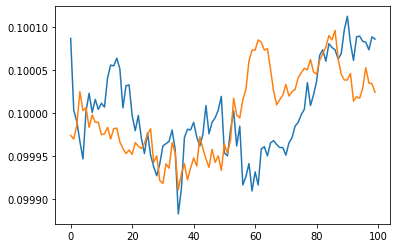

In [22]:
plt.plot(dataset_seq[20])
plt.plot(dataset_seq[200])

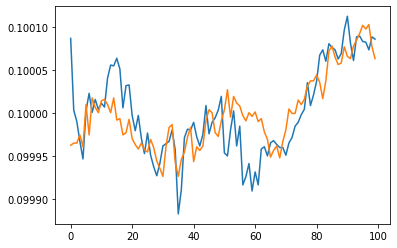

In [23]:
plt.plot(dataset_seq[20])
plt.plot(dataset_seq[133])

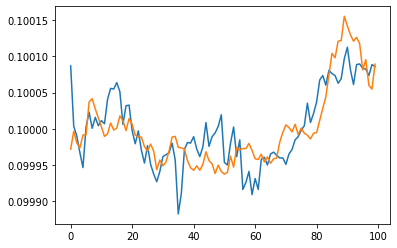

In [24]:
plt.plot(dataset_seq[20])
plt.plot(dataset_seq[32])